# Crunch Data

## Importe modules
First of all, we need to import some modules and define some constants [previously explained](data-collection.ipynb):

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

In [3]:
audio_duration = 1.0
sd.default.samplerate = 8000

dataset_dir = 'dataset'
men_dir = os.path.join(dataset_dir, 'men')
women_dir = os.path.join(dataset_dir, 'women')

## Loading data
In order to combact imbalance data, we check that the number of male samples is roughly the same as the number of female labels. The reason is that not balanced datasets can lead to the [Accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox).

In [7]:
def file_list(path):
    return [os.path.join(path, filename) for filename in os.listdir(path)]

men_files, women_files = file_list(men_dir), file_list(women_dir)
n_men, n_women = len(men_files), len(women_files)

print('Number of men samples:', n_men)
print('Number of women samples:', n_women)

Number of men samples: 28
Number of women samples: 22


In [8]:
def load_from_disk(files):
    # NB: I call the .flatten() function to make sure that every sample have the (N) shape and not the (N, 1)
    samples = [np.load(file) for file in files]
    return np.stack(samples, axis=0)

men_samples = load_from_disk(men_files)
women_samples = load_from_disk(women_files)

## Data preparation

In  this phase we obtain the values associated with the features of our ML model.

To better understand what's going on, I decided to plot the first result every time there is an operation over every element in a list.

### Fourier transform
For every sample I calculated its fourier transform. In particular:
* we consider only the absolute value of the intensity since we only want to know how much it contributes to the overall;
* we analyze only the [0, 280Hz] range, which [should contain](https://en.wikipedia.org/wiki/Voice_frequency#Fundamental_frequency) the fundamental frequency.
I did it because the fundamental frequency is related to the pitch and the pitch is related to the gender of the person who is speaking;
* we do a normalization over the intensities to bring all values into the range [0,1]. In this way we make the sampled voice volume-agnostic. We preserve the scaling factor in order to use it as a feature in our future ML model.

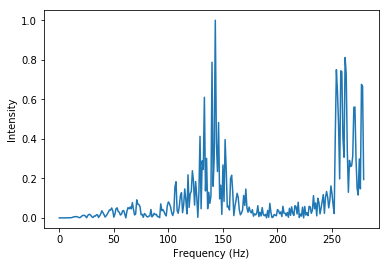

In [18]:
def get_freqs(voice):
    spectrum = np.abs(np.fft.fft(voice).real)
    freq_axis = np.fft.fftfreq(np.size(voice)) * sd.default.samplerate
    freq_axis_res = freq_axis[1] - freq_axis[0]
    
    positive_spectrum = spectrum[0:np.size(spectrum)//2]
    positive_axis = freq_axis[0:np.size(spectrum)//2]

    voice_spectrum = positive_spectrum[0:int(280/freq_axis_res)]
    freq_axis = positive_axis[0:int(280/freq_axis_res)]
    
    max_i = np.max(voice_spectrum)
    spectrum_scaled = voice_spectrum / max_i
    return freq_axis, spectrum_scaled, max_i

def get_freqs_of_everyone(samples):
    data = [get_freqs(sample) for sample in men_samples]
    return np.stack(data, axis=0)

men_fouriers = get_freqs_of_everyone(men_samples)
women_fouries = get_freqs_of_everyone(women_samples)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Intensity')
plt.plot(men_fouriers[0][0], men_fouriers[0][1])
plt.show()

### Calculate features

*WORK IN PROGRESS*